In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Завантаження та підготовка даних MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Конвертація зображення у тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормалізація зображення
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Побудова моделі CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

# Визначення функції втрат та оптимізатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функція для генерації адверсаріальних зразків за допомогою FGSM
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Обмеження значень пікселів до діапазону [0, 1]
    return perturbed_image

# Адверсаріальне навчання моделі
num_epochs = 5
epsilon = 0.1  # Значення епсилону
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        data_grad = images.grad.data
        # Adding perturbed images to a training set
        # perturbed_images = fgsm_attack(images, epsilon, data_grad)
        # perturbed_outputs = model(perturbed_images)
        # perturbed_loss = criterion(perturbed_outputs, labels)
        total_loss = loss
        optimizer.step()

    # Оцінка моделі після кожної епохи
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Epoch [{}/{}], Accuracy on test data: {:.2f}%'.format(epoch+1, num_epochs, accuracy * 100))

# Збереження навченої моделі
torch.save(model, 'basic_mnist_cnn_model.pth')


Epoch [1/5], Accuracy on test data: 98.32%
Epoch [2/5], Accuracy on test data: 98.97%
Epoch [3/5], Accuracy on test data: 98.90%
Epoch [4/5], Accuracy on test data: 99.08%
Epoch [5/5], Accuracy on test data: 99.00%


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Функція для генерації адверсаріальних зображень за допомогою FGSM
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Обмеження значень пікселів до діапазону [0, 1]
    return perturbed_image

# Завантаження натренованої моделі
model = torch.load('basic_mnist_cnn_model.pth')
model.eval()

# Завантаження та підготовка тестових даних MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Конвертація зображення у тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормалізація зображення
])

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Значення епсилонів для перевірки
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]

# Перевірка точності моделі на тестовому наборі даних для кожного значення епсілону
for epsilon in epsilons:
    correct_adversarial = 0
    total = 0

    for images, labels in test_loader:
        images.requires_grad = True
        outputs = model(images)
        loss = nn.CrossEntropyLoss()
        loss_cal = loss(outputs, labels)
        loss_cal.backward()
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
        perturbed_outputs = model(perturbed_images)
        _, perturbed_predicted = torch.max(perturbed_outputs.data, 1)
        correct_adversarial += (perturbed_predicted == labels).sum().item()
        total += labels.size(0)

    accuracy_adversarial = correct_adversarial / total
    print('Epsilon: {:.2f}, Accuracy on adversarial test data: {:.2f}%'.format(epsilon, accuracy_adversarial * 100))


Epsilon: 0.01, Accuracy on adversarial test data: 98.00%
Epsilon: 0.05, Accuracy on adversarial test data: 96.98%
Epsilon: 0.10, Accuracy on adversarial test data: 95.18%
Epsilon: 0.20, Accuracy on adversarial test data: 88.69%
Epsilon: 0.50, Accuracy on adversarial test data: 48.80%


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load and prepare the MNIST training and test datasets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
model.train()
for epoch in range(10):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Evaluate the model's accuracy on the training dataset
def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

accuracy_before_poisoning = evaluate_model(model, train_loader)
print('Accuracy on clean training data before poisoning: {:.2f}%'.format(accuracy_before_poisoning * 100))

# Now, let's perform the poisoning attack and retrain the model on the poisoned dataset
def poisoning_attack(data_loader, percentage=0.1, target_label=7):
    poisoned_data = []
    num_poisoned_batches = int(len(data_loader.dataset) * percentage)
    for idx, (images, labels) in enumerate(data_loader):
        if idx < num_poisoned_batches:
            images, labels = images.to(device), labels.to(device)
            labels[:] = target_label
        poisoned_data.append((images, labels))
    return poisoned_data

# Poison the training dataset
poisoned_train_loader = poisoning_attack(train_loader)

# Retrain the model on the poisoned data
model.train()
for epoch in range(10):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(poisoned_train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Retraining')

accuracy_after_poisoning = evaluate_model(model, poisoned_train_loader)
print('Accuracy on poisoned training data: {:.2f}%'.format(accuracy_after_poisoning * 100))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16364093.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490013.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4520287.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4411887.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Finished Training
Accuracy on clean training data before poisoning: 99.84%
Finished Retraining
Accuracy on poisoned training data: 100.00%


In [ ]:
accuracy_after_poisoning = evaluate_model(model, test_loader)
print('Accuracy on clean test data after poisoning: {:.2f}%'.format(accuracy_after_poisoning * 100))

Accuracy on clean test data after poisoning: 10.28%


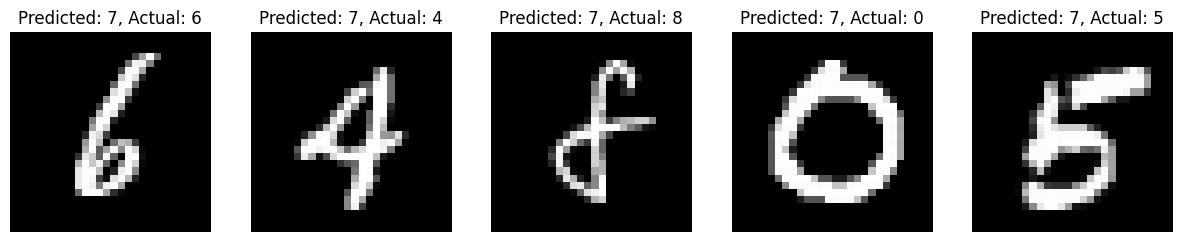

In [7]:
import matplotlib.pyplot as plt

# Get a batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Move the images and labels to the CPU
images = images.cpu()
labels = labels.cpu()

# Get the model's predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.cpu()

# Plot the images with their predicted and actual labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Predicted: {predicted[i]}, Actual: {labels[i]}')
    ax.axis('off')

plt.show()